In [1]:
import random
import lr_scheduler
import matplotlib.pyplot as plt
#from func import *
import func
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from PIL import Image
import cv2

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.initializers import GlorotUniform
from PIL import Image, ImageEnhance

folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

images = []
npy_file = []
for jpg_path, npy_path in file_pairs:
    images.append(func.read_jpg_files(jpg_path))
    npy_file.append(func.read_and_parse_npy_file(npy_path))

In [2]:
AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42

PROJECT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
# encoder
def concat_encoder():
    # Input 
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")  
    npy_input = layers.Input(shape=(8,), name="npy_input") 

    # x1: CNN output shape (30)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Dropout(0.3)(x1)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Dropout(0.3)(x1)

    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(20, activation='relu', name="cnn_output")(x1)

    # x2: read npy_file with shape (8)
    x2 = layers.Dense(10, activation='relu', name="npy_output")(npy_input)
    # x3: x1 + x2
    x3 = layers.Concatenate(name="combined_features")([x1, x2])
    
    # # straight npy_file shape (8)
    # x3 = layers.Concatenate(name="combined_features")([x1, npy_input])

    # Fully connected layers
    # x = layers.Dense(128, activation="relu", name="dense_128")(x3)
    # x = layers.Dense(64, activation="relu", name="dense_64")(x)
    # x = layers.Dense(32, activation=None, name="projection_head")(x)  # Projection head

    x = layers.Dense(32, activation=None, name="projection_head")(x3)  # Projection head
    # Model
    model = models.Model(inputs=[image_input, npy_input], outputs=x, name="encoder")
    return model

In [4]:
# def concat_encoder():
#     # Input 
#     image_input = layers.Input(shape=(128, 128, 1), name="image_input")  
#     npy_input = layers.Input(shape=(8,), name="npy_input") 

#     # Modify ResNet-50 for grayscale input
#     resnet_base = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

#     # Preprocess the grayscale input to have 3 channels (simulating RGB)
#     x1 = layers.Conv2D(3, (1, 1), padding='same', name="grayscale_to_rgb")(image_input)
#     x1 = preprocess_input(x1)

#     # Pass through ResNet-50
#     x1 = resnet_base(x1)
#     x1 = layers.GlobalAveragePooling2D(name="gap_output")(x1)
#     #x1 = layers.Flatten(name="flatten_output")(x1)
#     x1 = layers.Dense(30, activation='relu', name="cnn_output", kernel_initializer=GlorotUniform())(x1)


#     # Concatenate with npy_input
#     #x3 = layers.Concatenate(name="combined_features")([x1, npy_input])

#     #x2: read npy_file with shape ()
#     x2 = layers.Dense(10, activation='relu', name="npy_output")(npy_input)
#     #x3: x1 + x2
#     x3 = layers.Concatenate(name="combined_features")([x1, x2])

#     # Fully connected layers
#     # x = layers.Dense(128, activation="relu", name="dense_128")(x3)
#     # x = layers.Dense(64, activation="relu", name="dense_64")(x)
#     x = layers.Dense(32, activation=None, name="projection_head")(x3)  # Projection head

#     # Model
#     model = models.Model(inputs=[image_input, npy_input], outputs=x, name="encoder")
#     return model

In [5]:
# def concat_encoder():
#     # Input 
#     image_input = layers.Input(shape=(128, 128, 1), name="image_input")  
#     npy_input = layers.Input(shape=(8,), name="npy_input") 

#     resnet_base = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))
#     x1 = layers.Conv2D(3, (1, 1), padding='same', name="grayscale_to_rgb")(image_input)
#     x1 = preprocess_input(x1)

#     x1 = resnet_base(x1)
#     x1 = layers.GlobalAveragePooling2D(name="gap_output")(x1)
    
#     # Skip connection for Dense
#     cnn_skip = x1  # Save ResNet-50 output before Dense
#     x1 = layers.Dense(30, activation='relu', name="cnn_output", kernel_initializer=GlorotUniform())(x1)
#     x1 = layers.Add(name="cnn_skip_connection")([cnn_skip, x1])  # Skip connection

#     # Process npy_input
#     x2 = layers.Dense(10, activation='relu', name="npy_output")(npy_input)

#     # Concatenate features
#     x3 = layers.Concatenate(name="combined_features")([x1, x2])

#     # Fully connected layers
#     x = layers.Dense(32, activation=None, name="projection_head")(x3)  # Projection head

#     # Model
#     model = models.Model(inputs=[image_input, npy_input], outputs=x, name="encoder")
#     return model


### Traning

In [6]:
# Augmentation Functions
# No1. Augmentation Functions
# def augment_image(image):
#     # """"
#     # random flip + random crop
#     # """
#     # if random.random() > 0.5:
#     #     image = np.fliplr(image) # left right
#     # if random.random() > 0.5:
#     #     image = np.flipud(image) # up down
    
#     # crop_size = random.randint(5, 20)
#     # h, w = image.shape
#     # cropped_image = image[crop_size:h-crop_size, crop_size:w-crop_size]
#     # # Resize lại về kích thước ban đầu
#     # augmented_image = np.pad(cropped_image, ((crop_size, crop_size), (crop_size, crop_size)), mode='constant', constant_values=77)
#     # return augmented_image
#     return image


def augment_image(image, crop_ratio=0.05):
    h, w = image.shape
    # Calculate crop dimensions
    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)

    # cropping
    cropped_image = image[crop_h:h-crop_h, crop_w:w-crop_w]

    # Resize back to original
    resized_image = cv2.resize(cropped_image, (w, h), interpolation=cv2.INTER_LINEAR)

    return resized_image

# No2. Augmentation Functions
def adjust_brightness(image, factor=1.1):
    """
    scale pixel values
    """
    adjusted = np.clip(image * factor, 0, 255).astype(np.uint8)
    return adjusted

def add_noise_vector(vector,alpha= 0.01):
    noise = np.random.normal(0, alpha, size=len(vector)) # alpha standard deviation
    augmented_vector = [v + n for v, n in zip(vector, noise)]
    #augmented_vector = [i.astype(float) for i in augmented_vector]
    return augmented_vector


In [7]:
# learning rate
STEPS_PER_EPOCH = 597 // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = lr_scheduler.WarmUpCosine(
    learning_rate_base=5e-4,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

#lr_decayed_fn = 5e-4

In [8]:
# create train loss data
# image
image1 = [augment_image(img) for img in images]
image2 = [adjust_brightness(img, factor=1.2) for img in images]

# noise
npy_file_1 = [add_noise_vector(i,alpha= 0.05) for i in npy_file]
npy_file_2 = [add_noise_vector(i,alpha= 0.10) for i in npy_file]

# Normalize
image1 = [(i.astype("float32") / 255.0) for i in image1]
image2 = [(i.astype("float32") / 255.0) for i in image2]

scaler = StandardScaler()
npy_file_1 = scaler.fit_transform(npy_file_1)
npy_file_2 = scaler.fit_transform(npy_file_2)

dataset1 = tf.data.Dataset.from_tensor_slices((image1, npy_file_1)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset2 = tf.data.Dataset.from_tensor_slices((image2, npy_file_2)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

BL_ds = tf.data.Dataset.zip((dataset1, dataset2))
BL_ds_test = BL_ds

Epoch 1/10


f:\code\barlow\env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'npy_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - loss: 8.6701
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - loss: 3.7775
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - loss: 2.0396
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - loss: 2.0618
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - loss: 1.9682
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 348ms/step - loss: 1.8743
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - loss: 1.8375
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - loss: 1.8051
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - loss: 1.7967
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - loss: 1.7907


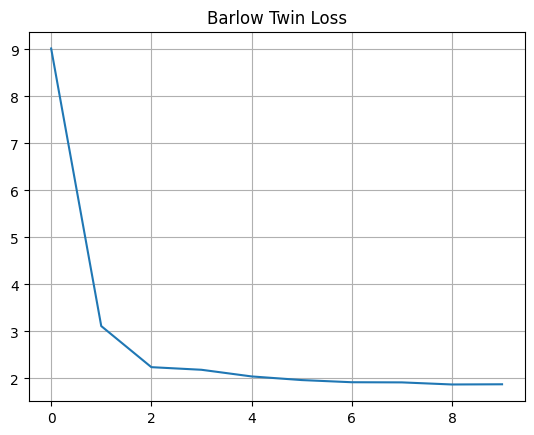

In [9]:
# Create Barlow Twins
encoder = concat_encoder()
barlow_twins = func.BarlowTwins(encoder=encoder, lambd=5e-3)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins.compile(optimizer=optimizer)
history = barlow_twins.fit(BL_ds_test, epochs=EPOCHS)

plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

# Save
#barlow_twins.save_weights('bl_test2.weights.h5')

### Classify

In [10]:
# func
def process_data(data_list):
    a = []
    b = []
    for jpg_path, npy_path in data_list:
        a.append(func.read_jpg_files(jpg_path))
        b.append(func.read_and_parse_npy_file(npy_path))
    return a,b

In [11]:
# create train test dataset
train_similar, train_dissimilar, test_similar, test_dissimilar = func.split_and_shuffle_pairs(file_pairs, folder_path)

xtrain1 = process_data(train_similar)
xtrain2 = process_data(train_dissimilar)
xtest1 = process_data(test_similar)
xtest2 = process_data(test_dissimilar)

# label 1 - similar, 0 - disimilar
ytrain1 = [1] * 500
ytrain2 = [0] * 500
ytest1 = [1] *79
ytest2 = [0] *79

#
t1 = np.array([np.expand_dims(item, axis=-1) for item in xtrain1[0]])  # Expand dims
t1 = t1.astype("float32") / 255.0  # Normalize to [0, 1]
t2 = np.array([item for item in xtrain1[1]])  # NPY input
t2 = scaler.fit_transform(t2)  # Standardize to mean=0, std=1
train_ds1 = tf.data.Dataset.from_tensor_slices(((t1, t2), ytrain1))

#
t3 = np.array([np.expand_dims(item, axis=-1) for item in xtrain2[0]])  # Expand dims
t3 = t3.astype("float32") / 255.0  # Normalize to [0, 1]
t4 = np.array([item for item in xtrain2[1]])  # NPY input
t4 = scaler.transform(t4)  # Sử dụng scaler đã fit từ trước
train_ds2 = tf.data.Dataset.from_tensor_slices(((t3, t4), ytrain2))


# concat
train_ds = train_ds1.concatenate(train_ds2)
train_ds = train_ds.shuffle(buffer_size=1000, seed=226)
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

#
t5 = np.array([np.expand_dims(item, axis=-1) for item in xtest1[0]])  # Expand dims
t5 = t5.astype("float32") / 255.0  # Normalize to [0, 1]
t6 = np.array([item for item in xtest1[1]])  # NPY input
t6 = scaler.transform(t6)  # Sử dụng scaler đã fit từ dữ liệu training
test_ds1 = tf.data.Dataset.from_tensor_slices(((t5, t6), ytest1))

#
t7 = np.array([np.expand_dims(item, axis=-1) for item in xtest2[0]])  # Expand dims
t7 = t7.astype("float32") / 255.0  # Normalize to [0, 1]
t8 = np.array([item for item in xtest2[1]])  # NPY input
t8 = scaler.transform(t8)  # Sử dụng scaler đã fit từ dữ liệu training
test_ds2 = tf.data.Dataset.from_tensor_slices(((t7, t8), ytest2))

#
test_ds = test_ds1.concatenate(test_ds2)
test_ds = test_ds.shuffle(buffer_size=1000, seed=226)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
# # create encoder 
# encoder = concat_encoder()
# barlow_twins = func.BarlowTwins(encoder=encoder)


backbone = tf.keras.Model(
    inputs=barlow_twins.encoder.input,
    outputs=barlow_twins.encoder.layers[-1].output  # output từ lớp Dense(16)
)
# Freeze 
#barlow_twins.load_weights('bl_test2.weights.h5')
backbone.trainable = False

In [18]:
# add classify layer
inputs = backbone.input
x = backbone.output
outputs = layers.Dense(2, activation="relu", name="classifier")(x)

# Classify model
test_model = tf.keras.Model(inputs, outputs, name="test_model")

# Compile model
test_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.00002)
)

history = test_model.fit(
    train_ds, validation_data=test_ds, epochs=100
)

_, test_acc = test_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5114 - loss: 3.8510 - val_accuracy: 0.4747 - val_loss: 2.4343
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4971 - loss: 2.4602 - val_accuracy: 0.4747 - val_loss: 0.8268
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5046 - loss: 0.7215 - val_accuracy: 0.4747 - val_loss: 0.7240
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5157 - loss: 0.7037 - val_accuracy: 0.4747 - val_loss: 0.7162
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4902 - loss: 0.7025 - val_accuracy: 0.4747 - val_loss: 0.7120
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5008 - loss: 0.6910 - val_accuracy: 0.4747 - val_loss: 0.7089
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5102 - loss: 0.6920 - val_accuracy: 0.4747 - val_loss: 0.7069
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5063 - loss: 0.6969 - val_accuracy: 0.

In [19]:
# print
# Predict on the test dataset
predictions = test_model.predict(test_ds)
# Extract the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Print predictions and true labels
for i, prediction in enumerate(predictions):
    predicted_label = np.argmax(prediction)  # Get the predicted class index
    print(f"Sample {i} --- Result:{prediction}")
    print(f"Predicted Label = {predicted_label}, True Label = {true_labels[i]}")


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C36F55A9E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sample 0 --- Result:[2.2045531 4.582402 ]
Predicted Label = 1, True Label = 1
Sample 1 --- Result:[4.978539  1.7666178]
Predicted Label = 0, True Label = 1
Sample 2 --- Result:[1.4480395 3.0278285]
